In [ ]:
!tesseract --version


tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8


In [ ]:

!pip install pytesseract


In [ ]:
pytesseract.pytesseract.tesseract_cmd = "/usr/bin/tesseract"


In [ ]:
!apt-get install -y tesseract-ocr


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!apt-get install -y tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 29 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (3,339 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 126772 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
!apt-get -qq install -y xvfb
!pip install pyvirtualdisplay

import pyvirtualdisplay
import tkinter as tk  # Import tkinter
from tkinter import filedialog, messagebox
from PIL import Image, ImageTk
import cv2
import numpy as np
import imutils
import pytesseract
import os

# Create a virtual display
_display = pyvirtualdisplay.Display(visible=False, size=(800, 600))
_ = _display.start()  # Start the virtual display

# Set DISPLAY environment variable
os.environ["DISPLAY"] = f":{_display.display}"


class AdvancedLicensePlateDetector:
    def __init__(self, master):
        self.master = master
        self.master.title("Advanced License Plate Detection")
        self.master.geometry("800x600")

        # Setup UI
        self.setup_ui()

        # Initialize variables
        self.original_image = None
        self.plate_image = None

    def setup_ui(self):
        # Main Frame
        main_frame = tk.Frame(self.master)
        main_frame.pack(padx=10, pady=10, fill=tk.BOTH, expand=True)

        # Original Image Frame
        original_frame = tk.LabelFrame(main_frame, text="Original Image")
        original_frame.pack(side=tk.LEFT, padx=5, pady=5, fill=tk.BOTH, expand=True)

        self.original_label = tk.Label(original_frame)
        self.original_label.pack(padx=5, pady=5)

        # Plate Image Frame
        plate_frame = tk.LabelFrame(main_frame, text="Detected Plate")
        plate_frame.pack(side=tk.LEFT, padx=5, pady=5, fill=tk.BOTH, expand=True)

        self.plate_label = tk.Label(plate_frame)
        self.plate_label.pack(padx=5, pady=5)

        # Button Frame
        button_frame = tk.Frame(self.master)
        button_frame.pack(pady=10)

        # Select Image Button
        select_button = tk.Button(
            button_frame,
            text="Select Vehicle Image",
            command=self.select_image
        )
        select_button.pack(side=tk.LEFT, padx=10)

        # Detect Plate Button
        detect_button = tk.Button(
            button_frame,
            text="Detect License Plate",
            command=self.detect_license_plate
        )
        detect_button.pack(side=tk.LEFT, padx=10)

        # Result Text
        self.result_var = tk.StringVar()
        result_label = tk.Label(
            self.master,
            textvariable=self.result_var,
            font=('Arial', 12)
        )
        result_label.pack(pady=10)

    def select_image(self):
        file_path = filedialog.askopenfilename(
            filetypes=[
                ("Image files", "*.jpg *.jpeg *.png *.bmp"),
                ("All files", "*.*")
            ]
        )

        if file_path:
            # Read the image
            self.original_image = cv2.imread(file_path)

            # Display original image
            self.display_image(self.original_image, self.original_label)

    def display_image(self, image, label):
        # Convert BGR to RGB
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Convert to PIL Image
        pil_image = Image.fromarray(image_rgb)

        # Resize image
        pil_image.thumbnail((350, 350))

        # Convert to PhotoImage
        photo = ImageTk.PhotoImage(pil_image)

        # Update label
        label.config(image=photo)
        label.image = photo

    def detect_license_plate(self):
        if self.original_image is None:
            messagebox.showerror("Error", "Please select an image first!")
            return

        try:
            # Preprocessing
            gray = cv2.cvtColor(self.original_image, cv2.COLOR_BGR2GRAY)

            # Apply bilateral filter to reduce noise
            gray = cv2.bilateralFilter(gray, 11, 17, 17)

            # Edge detection
            edged = cv2.Canny(gray, 170, 200)

            # Find contours
            keypoints = cv2.findContours(
                edged.copy(),
                cv2.RETR_TREE,
                cv2.CHAIN_APPROX_SIMPLE
            )
            contours = imutils.grab_contours(keypoints)
            contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

            # Initialize license plate contour
            plate_contour = None

            # Find potential license plate contour
            for c in contours:
                perimeter = cv2.arcLength(c, True)
                approx = cv2.approxPolyDP(c, 0.02 * perimeter, True)

                # Look for rectangular contour
                if len(approx) == 4:
                    plate_contour = approx
                    break

            if plate_contour is None:
                self.result_var.set("No License Plate Detected")
                return

            # Create mask and extract plate
            mask = np.zeros(gray.shape, np.uint8)
            new_image = cv2.drawContours(mask, [plate_contour], 0, 255, -1)
            new_image = cv2.bitwise_and(
                self.original_image,
                self.original_image,
                mask=mask
            )

            # Get plate coordinates
            (x, y) = np.where(mask == 255)
            (topx, topy) = (np.min(x), np.min(y))
            (bottomx, bottomy) = (np.max(x), np.max(y))

            # Crop plate
            plate_img = gray[topx:bottomx + 1, topy:bottomy + 1]

            # Enhance plate image
            plate_img = cv2.resize(plate_img, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
            plate_img = cv2.threshold(plate_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

            # OCR Configuration
            pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
            plate_text = pytesseract.image_to_string(
                plate_img,
                config='--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
            )

            # Clean up text
            plate_text = plate_text.strip().replace('\n', '').replace('\r', '')

            # Display plate image
            self.display_image(plate_img, self.plate_label)

            # Update result
            if plate_text:
                self.result_var.set(f"Detected Plate: {plate_text}")

                # Draw rectangle on original image
                cv2.drawContours(
                    self.original_image,
                    [plate_contour],
                    -1,
                    (0, 255, 0),
                    3
                )
                self.display_image(self.original_image, self.original_label)
            else:
                self.result_var.set("No Readable Plate Detected")

        except Exception as e:
            self.result_var.set(f"Error: {str(e)}")


def main():
    root = tk.Tk()
    app = AdvancedLicensePlateDetector(root)
    root.mainloop()


if __name__ == "__main__":
    main()


In [ ]:
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

# Set Tesseract path (adjust based on your system)
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

# Load the image
image_path = "/content/car1.jpg" # Replace with your image path
original_image = cv2.imread(image_path)

# Function to display images inline
def display_image(title, img, cmap=None):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()


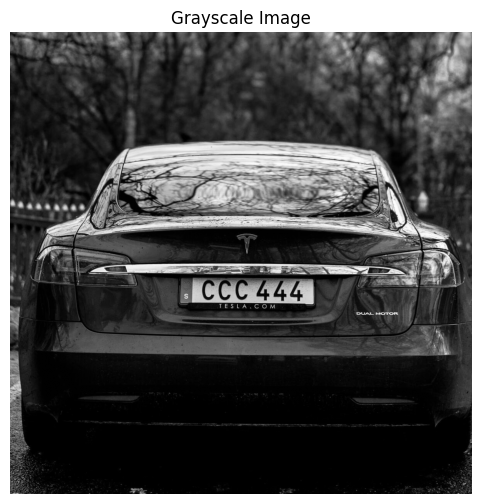

In [ ]:
# Convert to Grayscale
gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Display the grayscale image
display_image("Grayscale Image", gray, cmap='gray')


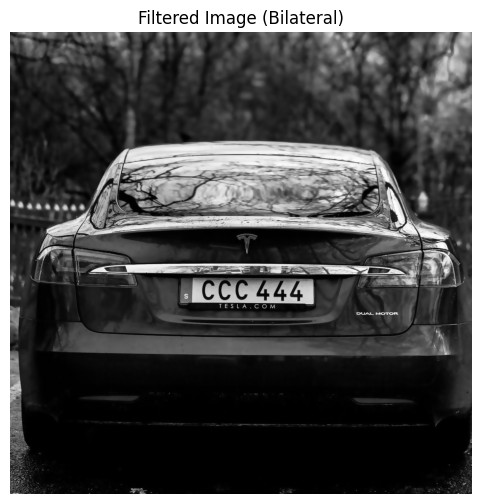

In [ ]:
# Apply Bilateral Filter for noise reduction
filtered = cv2.bilateralFilter(gray, 11, 17, 17)

# Display the filtered image
display_image("Filtered Image (Bilateral)", filtered, cmap='gray')


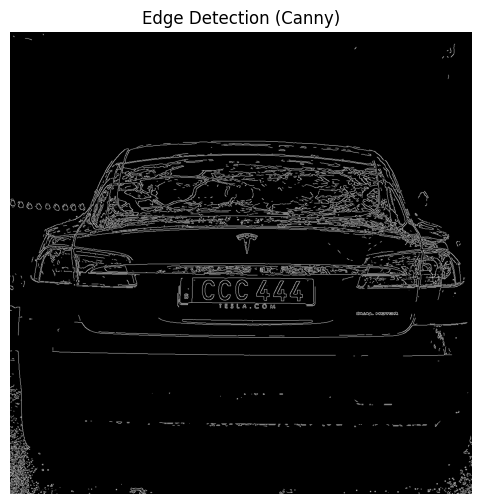

In [ ]:
# Perform Canny Edge Detection
edges = cv2.Canny(filtered, 170, 200)

# Display edges
display_image("Edge Detection (Canny)", edges, cmap='gray')


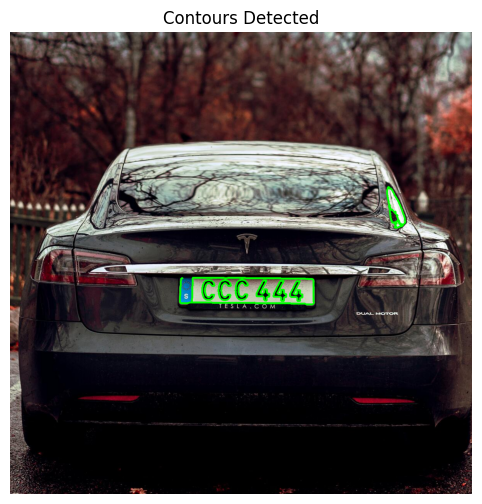

In [ ]:
# Find contours
keypoints = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2],
                  key=cv2.contourArea, reverse=True)[:10]

# Draw contours
contour_image = original_image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 3)

# Display contours
display_image("Contours Detected", cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))


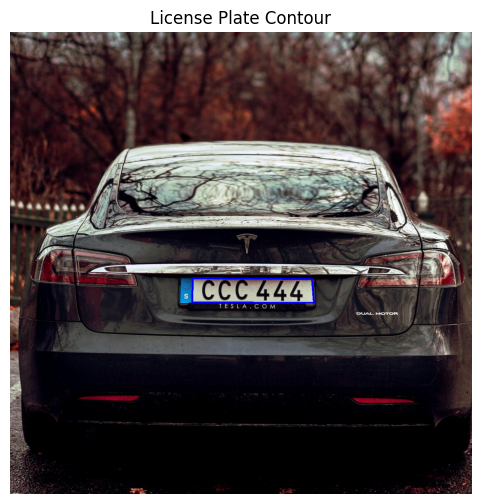

In [ ]:
# Look for rectangular contour
plate_contour = None
for contour in contours:
    perimeter = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.02 * perimeter, True)
    if len(approx) == 4:  # Check for rectangle
        plate_contour = approx
        break

if plate_contour is not None:
    # Draw the license plate contour
    contour_image = original_image.copy()
    cv2.drawContours(contour_image, [plate_contour], -1, (255, 0, 0), 3)
    display_image("License Plate Contour", cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
else:
    print("No license plate detected.")


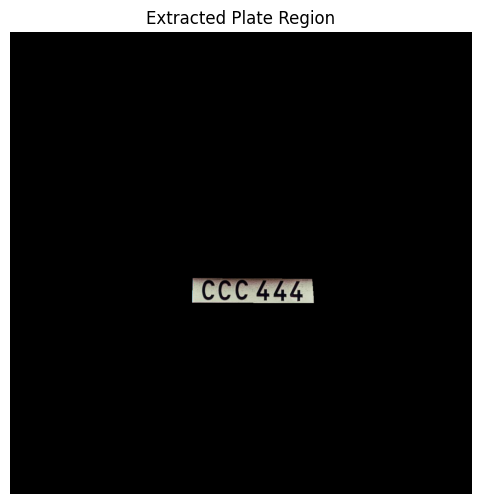

In [ ]:
if plate_contour is not None:
    # Create a mask for the detected plate
    mask = np.zeros(gray.shape, np.uint8)
    cv2.drawContours(mask, [plate_contour], 0, 255, -1)

    # Extract the license plate
    extracted_plate = cv2.bitwise_and(original_image, original_image, mask=mask)
    display_image("Extracted Plate Region", cv2.cvtColor(extracted_plate, cv2.COLOR_BGR2RGB))


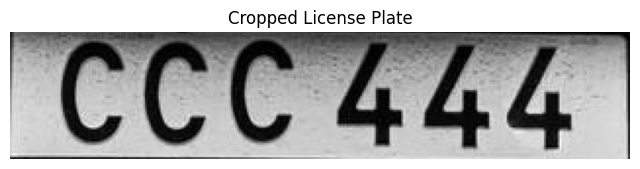

In [ ]:
if plate_contour is not None:
    # Get coordinates of the license plate region
    (x, y) = np.where(mask == 255)
    (topx, topy) = (np.min(x), np.min(y))
    (bottomx, bottomy) = (np.max(x), np.max(y))

    # Crop the license plate
    cropped_plate = gray[topx:bottomx+1, topy:bottomy+1]
    display_image("Cropped License Plate", cropped_plate, cmap='gray')


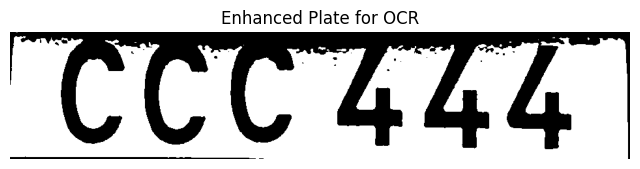

In [ ]:
if plate_contour is not None:
    # Resize and threshold for better OCR
    enhanced_plate = cv2.resize(cropped_plate, None, fx=3, fy=3, interpolation=cv2.INTER_CUBIC)
    enhanced_plate = cv2.threshold(enhanced_plate, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    display_image("Enhanced Plate for OCR", enhanced_plate, cmap='gray')


In [ ]:
if plate_contour is not None:
    # Perform OCR
    plate_text = pytesseract.image_to_string(
        enhanced_plate,
        config='--psm 8 --oem 3 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
    )
    plate_text = plate_text.strip().replace("\n", "").replace("\r", "")
    print(f"Detected License Plate Text: {plate_text}")
else:
    print("No license plate detected for OCR.")


Detected License Plate Text: CCC444
